In [1]:
import os
from os import listdir
from os.path import isfile, join
import wfdb
import numpy as np
import pandas as pd
from scipy.io import loadmat
from collections import Counter
import matplotlib.pyplot as plt

In [5]:
ecg_data = os.path.join(os.getcwd(), 'a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0/WFDBRecords')

hea_files = []
mat_files = []

for root, dirs, files in os.walk(ecg_data):
    for file in files:
        if file.endswith('.hea'):
            hea_files.append(os.path.join(root, file))
        elif file.endswith('.mat'):
            mat_files.append(os.path.join(root, file))

print('\nhea files:', len(hea_files))
print('mat files:', len(mat_files))


hea files: 45152
mat files: 45152


In [7]:
condition_counter = Counter()

mapping_file = os.path.join(os.getcwd(), 'a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0/ConditionNames_SNOMED-CT.csv')
mapping_df = pd.read_csv(mapping_file)
mapping_dict = dict(zip(mapping_df['Snomed_CT'], mapping_df['Full Name']))


for hea_file in hea_files:
    base_name = os.path.splitext(os.path.basename(hea_file))[0]
    
    header_path = os.path.join(os.path.dirname(hea_file), base_name)
    
    try:
        record = wfdb.rdheader(header_path)


        #extracting comments
        comments = record.comments[2].split(':')
        b = comments[1]
        b = b.split(",")
        diagnosis_code = []
        for x in b:
            diagnosis_code.append(int(x))
        
        for x in diagnosis_code:
            diagnosis_description = mapping_dict.get(x, 'Normal')
            condition_counter[diagnosis_description] += 1
       
    except FileNotFoundError:
        print(f'File not found: {hea_file}')
    except ValueError as e:
        print(f"Error downloading {record}: {e}")




Error downloading <wfdb.io.record.Record object at 0x17f556f10>: time data '/' does not match format '%d/%m/%Y'


Total number of conditions represented by the dataset: 52

8 most common conditions:
Normal: 16943
Sinus Bradycardia: 16559
Sinus Rhythm: 8125
Atrial Flutter: 8060
Sinus Tachycardia: 7254
T wave Change: 7043
T wave opposite: 2877
Sinus Irregularity: 2550


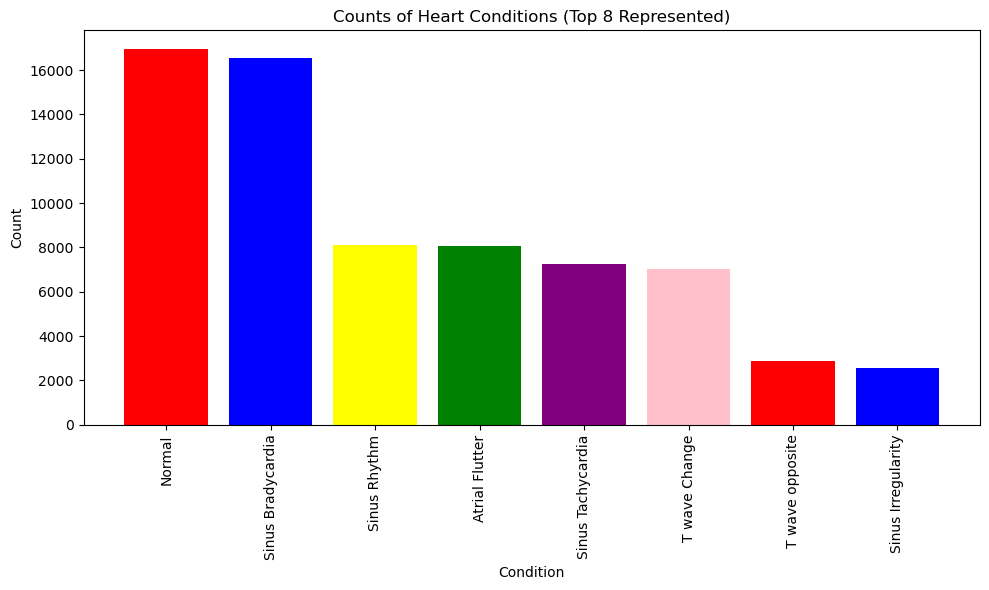

In [8]:
print(f'Total number of conditions represented by the dataset: {len(condition_counter)}')
print('\n8 most common conditions:')
for condition, count in condition_counter.most_common(8):
    print(f'{condition}: {count}')

top_conditions = condition_counter.most_common(8)
conditions, counts = zip(*top_conditions) if top_conditions else ([], [])

colours = ['red', 'blue', 'yellow','green', 'purple','pink']

plt.figure(figsize=(10, 6))
plt.bar(conditions, counts, color=colours)
plt.xlabel('Condition')
plt.ylabel('Count')
plt.title('Counts of Heart Conditions (Top 8 Represented)')
plt.xticks(rotation=90)  
plt.tight_layout()
plt.show()

In [12]:
classes_reducer = {
    'Normal': ['Normal', 'SB', 'SR', 'SA'], 
    'Supraventricular arrhythmia': ['AF', 'AFIB', 'ST', 'STDD', 'STTC', 'STE', 'STTU', 'SVT', 'AT', 'JEB', 'JPT', 'AVRT'],  
    'Ventricular arrhythmia': ['VPB', 'VEB', 'VFW', 'VPE', 'VET', 'VB'],  
    'Fusion beat': ['FQRS', 'APB'],  
    'Unknown': ['/', 'Q', 'f'],  
    'Other': ['TWC', 'TWO', 'ALS', '1AVB', 'AQW', 'LVQRSAL', 'ARS', 'IVB', 'RBBB', 'LVH', 'QTIE', 'ERV', 
              'LFBBB', 'CCR', 'PWC', 'UW', 'MISW', 'RVH', '3AVB', 'CR', 'WPW', '2AVB', 'PRIE', 'RAH', 
              '2AVB1', 'ABI', 'SAAWR']  
}

def reduce_classes(ecg_notes, classes_reducer):
    reduced_counter = Counter()
    
    reverse_mapping = {}
    for reduced_class, original_classes in classes_reducer.items():
        for original in original_classes:
            reverse_mapping[original] = reduced_class
            print(original)
            print(reduced_class)


    for original_class, count in ecg_notes.items():
        reduced_class = reverse_mapping.get(original_class, 'U')  
        reduced_counter[reduced_class] += count
    
    return reduced_counter


new = reduce_classes(condition_counter, classes_reducer)


print('\nMost Common Conditions:')
for condition, count in new.most_common():
    print(f'{condition}: {count}')

top_conditions = condition_counter.most_common()
conditions, counts = zip(*top_conditions) if top_conditions else ([], [])






Normal
Normal
Sinus Bradycardia
Normal
Sinus Rhythm
Normal
Sinus Arrhythmia
Normal
Atrial Fibrillation
Supraventricular arrhythmia
Atrial Flutter
Supraventricular arrhythmia
Sinus Tachycardia
Supraventricular arrhythmia
ST Depression
Supraventricular arrhythmia
ST Elevation
Supraventricular arrhythmia
Supraventricular Tachycardia
Supraventricular arrhythmia
Atrial Tachycardia
Supraventricular arrhythmia
Junctional Escape Beat
Supraventricular arrhythmia
Junctional Premature Beat
Supraventricular arrhythmia
Atrioventricular Reentrant Tachycardia
Supraventricular arrhythmia
Ventricular Premature Beat
Ventricular arrhythmia
Ventricular Escape Beat
Ventricular arrhythmia
Ventricular Flutter
Ventricular arrhythmia
Ventricular Premature Contraction
Ventricular arrhythmia
Ventricular Tachycardia
Ventricular arrhythmia
Ventricular Bigeminy
Ventricular arrhythmia
Fusion of QRS
Fusion beat
Atrial Premature Beat
Fusion beat
Uncertain
Unknown
Q
Unknown
f
Unknown
T-Wave Change
Other
T-Wave Alternan

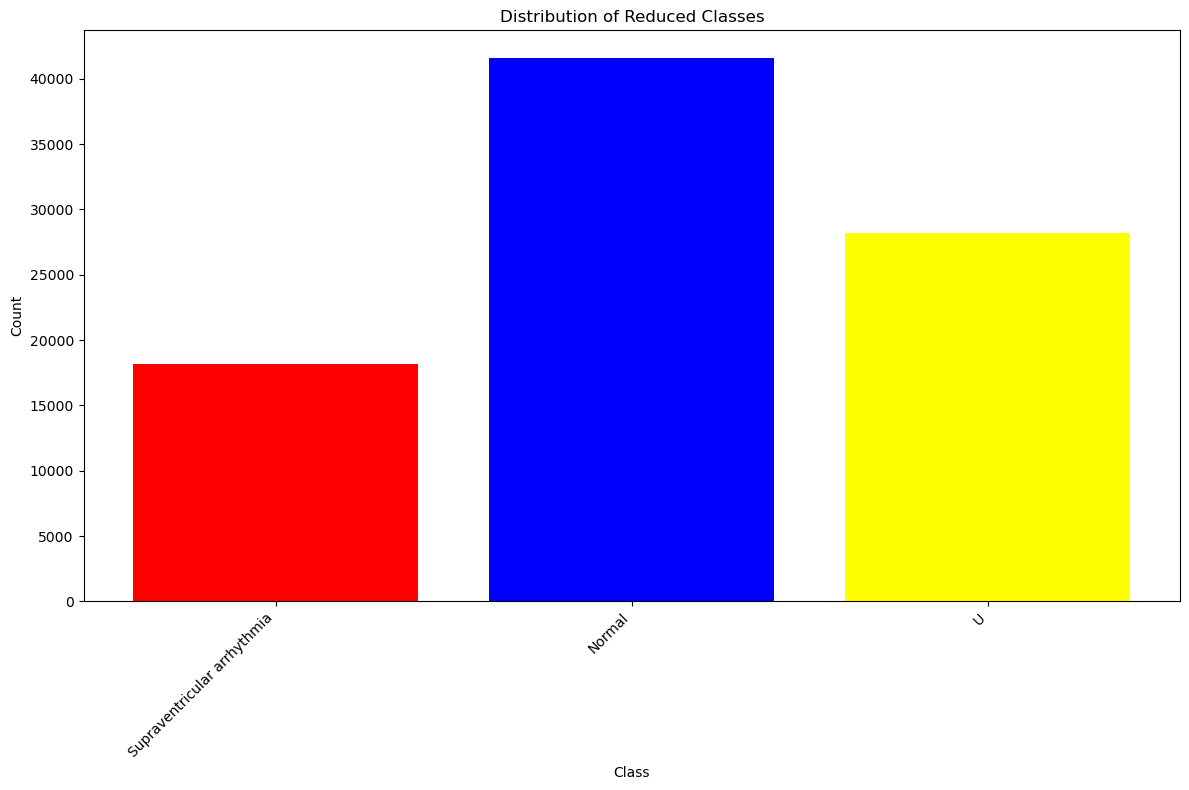

In [13]:
def plot_class_distribution(counter):

    categories = list(counter.keys())
    counts = list(counter.values())
    
    plt.figure(figsize=(12, 8))
    plt.bar(categories, counts, color=colours)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Distribution of Reduced Classes')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_class_distribution(new)